In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
def preprocess(dataset):
    dataset.rename(columns={'sentiment': 'Sentiment', 'review': 'Text'}, inplace=True)
    dataset['Sentiment'] = dataset['Sentiment'].replace({'negative': 0, 'positive': 1})
    dataset['Sentiment'] = dataset['Sentiment'].replace({'Negative': 0, 'Positive': 1})
    dataset = dataset.sample(frac=1, random_state=1).reset_index(drop=True)


In [5]:
original = pd.read_csv("IMDb/data/test_original.tsv", sep='\t')
preprocess(original)

/tmp/ipykernel_5459/2921636663.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Sentiment'] = dataset['Sentiment'].replace({'Negative': 0, 'Positive': 1})


In [6]:
contrast = pd.read_csv("IMDb/data/test_contrast.tsv", sep='\t')
preprocess(contrast)

/tmp/ipykernel_5459/2921636663.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Sentiment'] = dataset['Sentiment'].replace({'Negative': 0, 'Positive': 1})


In [7]:
def inference(*, prompt, sentence, tokenizer, model):
    inputs = tokenizer(prompt(sentence),  padding='max_length', return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=50)
    result = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    
    if "negative" in result.lower():
        return 0
    elif "positive" in result.lower():
        return 1
    else:
        return 2

In [8]:
import random


def build_example(dataset, index):
    return ("Text: " + dataset.Text[index] + "\nSentiment: " + ["negative","positive"][dataset.Sentiment[index]] + "\n\n")

def get_build_prompt(dataset, index, shots, system):
    def build_prompt(sent):
        ret = ""
        if(system):
            if(shots > 0):
                ret += "Classify the text into negative or positive. Here you have some examples:\n\n"
            else:
                ret += "Classify the text into negative or positive.\n\n"
        help_list = []
        for j in range(shots):
            help = random.sample(range(len(dataset)), 1)[0]
            while(index == help or help in help_list):
                help = random.sample(range(len(dataset)), 1)[0]
            help_list.append(help)
            example = build_example(dataset, help)
            ret += example
        ret += "Text: " + sent + "\nSentiment: "
        return ret
    return build_prompt


In [47]:
import random
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm


@torch.no_grad()
def eval(dataset, system):
    overall_results = dict()

    for shots in [0,1,2,3]:
        if(shots == 0):
             test = 1
        else:
            test = 3
        print("Running shot", shots)
        for run in range(test):
            print("Run", run)
            targets = []
            predictions = []
            total = len(dataset)
            
            for i in tqdm(range(total), total=total):
                prompt = get_build_prompt(dataset, i, shots, system)
                targets.append(dataset.Sentiment[i])
                predictions.append(inference(prompt=prompt, sentence=dataset.Text[i], tokenizer=tokenizer, model=model))
            
            right, wrong, no_sentiment = 0, 0, 0
            
            for j in range(len(predictions)):
                if(predictions[j] == 2):
                    no_sentiment += 1
                elif(targets[j] == predictions[j]):
                        right += 1
                elif(targets[j] != predictions[j]):
                        wrong += 1

            if shots not in overall_results:
                overall_results[shots] = dict()

            overall_results[shots][run] = {'correct' : right/len(predictions), 'wrong' : wrong/len(predictions), 'no_sentiment': no_sentiment/len(predictions)}
            # report = classification_report(targets, predictions, labels=[0,1,2], output_dict=True, zero_division=0)
            # overall_results[shots] = report

    return overall_results

In [15]:
import json
import csv

def write_csv(file_path, dataframe):
    csv_path = "csv/" + file_path + ".csv"
    json_path = "json/" + file_path + ".json"
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Scrittura dell'intestazione
        writer.writerow(['', '', file_path.replace("_results", ""), ''])
        writer.writerow(['', '', 'Errors', '', '', 'Errors', '', '', 'Errors', '', '', 'Errors'])
        writer.writerow(['Runs', 'Correct', 'Wrong', 'No_sentiment', 'Correct', 'Wrong', 'No_sentiment', 'Correct', 'Wrong', 'No_sentiment', 'Correct', 'Wrong', 'No_sentiment'])
        
        # Scrittura dei dati
        for j in range(3):
            field = ["Run " + str(j)]
            if(j != 0):
                field.append("")
                field.append("")
                field.append("")
            for shots, runs in dataframe.items():
                for run_number, metrics in runs.items():
                    if(run_number == j):
                        field.append(metrics['correct'])
                        field.append(metrics['wrong'])
                        field.append(metrics['no_sentiment'])
            writer.writerow(field)
    print(f"I dati sono stati scritti su {csv_path}.")

    with open(json_path, 'w') as f:
        json.dump(dataframe, f, sort_keys=True, indent=4)

In [16]:
SP_results_original_set = eval(dataset=original, system=True)

file = 'SP_original_results'

write_csv(file, SP_results_original_set)
# Scrittura dei dati su un file CSV

I dati sono stati scritti su csv/SP_original_results.csv.


In [19]:
results_original_set = eval(dataset=original, system=False)

file = 'original_results'

write_csv(file, results_original_set)

I dati sono stati scritti su csv/original_results.csv.


In [20]:
SP_results_contrast_set = eval(dataset=original, system=True)

csv_file = 'SP_contrast_results'

write_csv(file, SP_results_contrast_set)

Running shot 0
Run 0


100%|██████████| 488/488 [01:48<00:00,  4.51it/s]


Running shot 1
Run 0


100%|██████████| 488/488 [02:08<00:00,  3.79it/s]


Run 1


100%|██████████| 488/488 [02:07<00:00,  3.82it/s]


Run 2


100%|██████████| 488/488 [02:08<00:00,  3.80it/s]


Running shot 2
Run 0


100%|██████████| 488/488 [03:09<00:00,  2.57it/s]


Run 1


100%|██████████| 488/488 [03:07<00:00,  2.60it/s]


Run 2


100%|██████████| 488/488 [03:04<00:00,  2.65it/s]


Running shot 3
Run 0


100%|██████████| 488/488 [04:22<00:00,  1.86it/s]


Run 1


100%|██████████| 488/488 [04:22<00:00,  1.86it/s]


Run 2


100%|██████████| 488/488 [04:21<00:00,  1.87it/s]

I dati sono stati scritti su csv/original_results.csv.


In [21]:
results_contrast_set = eval(dataset=original, system=False)

csv_file = 'contrast_results'

write_csv(file, results_contrast_set)

Running shot 0
Run 0


100%|██████████| 488/488 [01:51<00:00,  4.38it/s]


Running shot 1
Run 0


100%|██████████| 488/488 [02:05<00:00,  3.88it/s]


Run 1


100%|██████████| 488/488 [02:06<00:00,  3.85it/s]


Run 2


100%|██████████| 488/488 [02:08<00:00,  3.80it/s]


Running shot 2
Run 0


100%|██████████| 488/488 [03:02<00:00,  2.68it/s]


Run 1


100%|██████████| 488/488 [03:01<00:00,  2.69it/s]


Run 2


100%|██████████| 488/488 [02:57<00:00,  2.75it/s]


Running shot 3
Run 0


100%|██████████| 488/488 [04:06<00:00,  1.98it/s]


Run 1


100%|██████████| 488/488 [04:09<00:00,  1.96it/s]


Run 2


100%|██████████| 488/488 [04:03<00:00,  2.00it/s]

I dati sono stati scritti su csv/original_results.csv.


In [22]:
def mean(data):
    averages = {}

    # Itera attraverso i numeri di aiuti
    for num_helps, runs in data.items():
        # Inizializza variabili per accumulare i valori
        total_correct = 0
        total_wrong = 0
        total_no_sentiment = 0
        
        # Conta il numero di run per questo numero di aiuti
        num_runs = len(runs)
        
        # Accumula i valori delle run
        for run in runs.values():
            total_correct += run['correct']
            total_wrong += run['wrong']
            total_no_sentiment += run['no_sentiment']
        
        # Calcola la media dei valori
        averages[num_helps] = {
            'correct': total_correct / num_runs,
            'wrong': total_wrong / num_runs,
            'no_sentiment': total_no_sentiment / num_runs
        }
    return averages


In [23]:
SP_original_mean = mean(SP_results_original_set)

SP_contrast_mean = mean(SP_results_contrast_set)

original_mean = mean(results_original_set)

contrast_mean = mean(results_contrast_set)

In [32]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

accuracy = dict()

def add_accuracy(data, name):
    for shot, metrics in data.items():
        if shot not in accuracy:
            accuracy[shot] = dict()
        accuracy[shot][name] = metrics['correct']


In [33]:
add_accuracy(SP_original_mean, 'SP_Original')
add_accuracy(SP_contrast_mean, 'SP_Contrast')
add_accuracy(original_mean, 'Original')
add_accuracy(contrast_mean, 'Contrast')

In [34]:
print(accuracy)

{0: {'SP_Original': 0.9569672131147541, 'SP_Contrast': 0.9569672131147541, 'Original': 0.9549180327868853, 'Contrast': 0.9549180327868853}, 1: {'SP_Original': 0.9596994535519126, 'SP_Contrast': 0.9583333333333334, 'Original': 0.9624316939890711, 'Contrast': 0.9610655737704917}, 2: {'SP_Original': 0.9617486338797815, 'SP_Contrast': 0.9590163934426229, 'Original': 0.9610655737704917, 'Contrast': 0.9596994535519127}, 3: {'SP_Original': 0.9624316939890711, 'SP_Contrast': 0.9637978142076502, 'Original': 0.9603825136612022, 'Contrast': 0.9631147540983607}}


In [35]:
csv_file = 'csv/accuracy.csv'

# Scrittura dei dati su un file CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Scrittura dell'intestazione
    writer.writerow(["", "SP_Original", "SP_Contrast", "Original", "Contrast"])
    
    # Scrittura dei dati
    for shot, types in accuracy.items():
        field = ["Help=" + str(shot)]
        for type, value in types.items():
            field.append(value) 
        writer.writerow(field) 
print(f"I dati sono stati scritti su {csv_file}.")

with open('accuracy.json', 'w') as f:
    json.dump(accuracy, f, sort_keys=True, indent=4)

I dati sono stati scritti su csv/accuracy.csv.


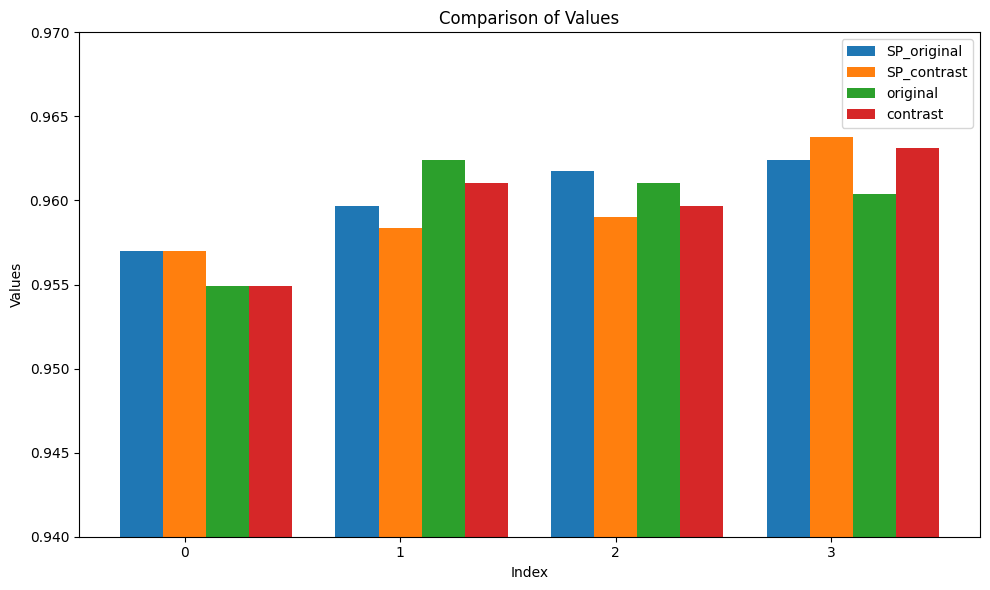

In [36]:
indices = list(accuracy.keys())

# Estrai tutti i valori per 'SP_original', 'SP_contrast', 'original', 'contrast'
SP_original_values = [accuracy[i]['SP_Original'] for i in indices]
SP_contrast_values = [accuracy[i]['SP_Contrast'] for i in indices]
original_values = [accuracy[i]['Original'] for i in indices]
contrast_values = [accuracy[i]['Contrast'] for i in indices]

# Larghezza delle barre
bar_width = 0.2

# Posizioni per gli indici
index = np.arange(len(indices))

# Crea il plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.ylim(0.94, 0.97)
bar1 = ax.bar(index - bar_width, SP_original_values, bar_width, label='SP_original')
bar2 = ax.bar(index, SP_contrast_values, bar_width, label='SP_contrast')
bar3 = ax.bar(index + bar_width, original_values, bar_width, label='original')
bar4 = ax.bar(index + 2*bar_width, contrast_values, bar_width, label='contrast')

# Etichette, titoli e legenda
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Comparison of Values')
ax.set_xticks(index)
ax.set_xticklabels(indices)
ax.legend()

plt.tight_layout()
plt.show()

In [5]:
# import json
# with open("json/SP_original_results.json", "r") as file:
#     SP_results_original_set = json.load(file)

# with open("json/SP_contrast_results.json", "r") as file:
#     SP_results_contrast_set = json.load(file)

# with open("json/original_results.json", "r") as file:
#     results_original_set = json.load(file)

# with open("json/contrast_results.json", "r") as file:
#     results_contrast_set = json.load(file)

In [63]:
from matplotlib import pyplot as plt
import numpy as np

def plot_dataframe(data, title):
    # Estrazione dei dati
    shots = list(data.keys())
    correct_values = [data[shot]['correct'] for shot in shots]
    wrong_values = [data[shot]['wrong'] for shot in shots]
    no_sentiment_values = [data[shot]['no_sentiment'] for shot in shots]

    # Larghezza delle barre
    bar_width = 0.25

    # Posizioni delle barre
    r1 = np.arange(len(shots))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Creazione del plot
    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(r1, correct_values, color='b', width=bar_width, edgecolor='grey', label='Correct')
    bars2 = ax.bar(r2, wrong_values, color='r', width=bar_width, edgecolor='grey', label='Wrong')
    bars3 = ax.bar(r3, no_sentiment_values, color='g', width=bar_width, edgecolor='grey', label='No Sentiment')

    # Aggiunta delle etichette e del titolo
    ax.set_xlabel('Number of Helps', fontweight='bold')
    ax.set_ylabel('Values', fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.set_xticks([r + bar_width for r in range(len(shots))])
    ax.set_xticklabels(shots)
    ax.legend()

    # Aggiunta dei valori delle barre con precisione a 3 cifre decimali
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

    for bar in bars3:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

    # Mostra il plot
    plt.show()

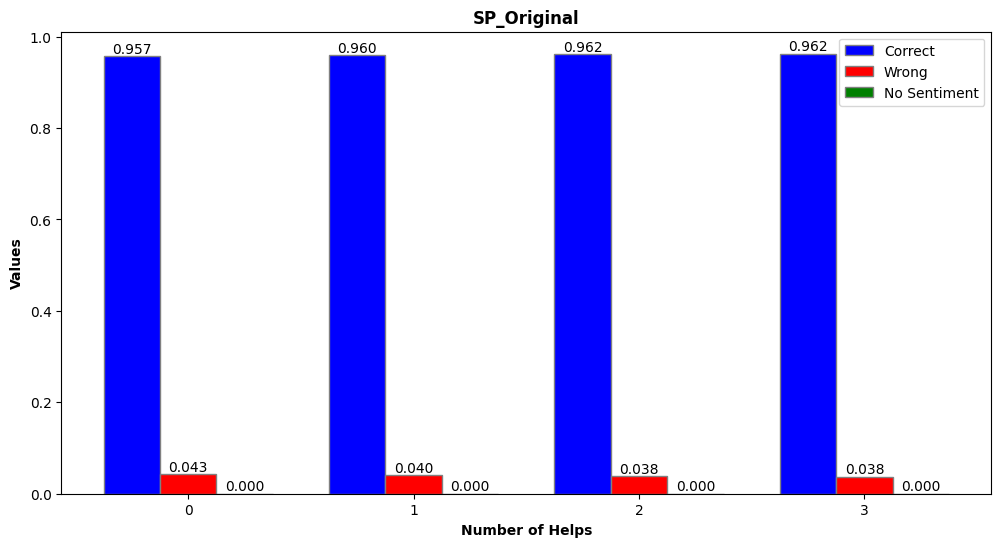

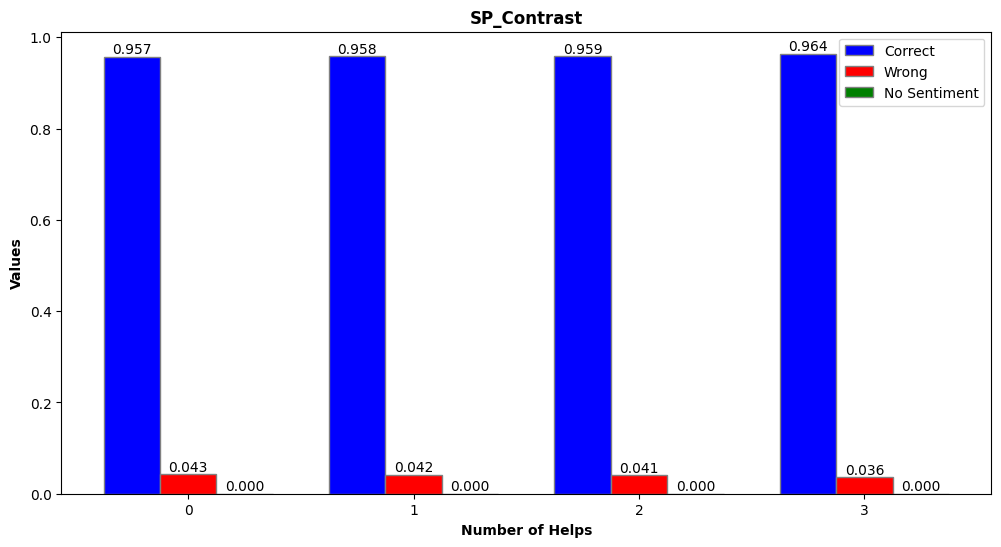

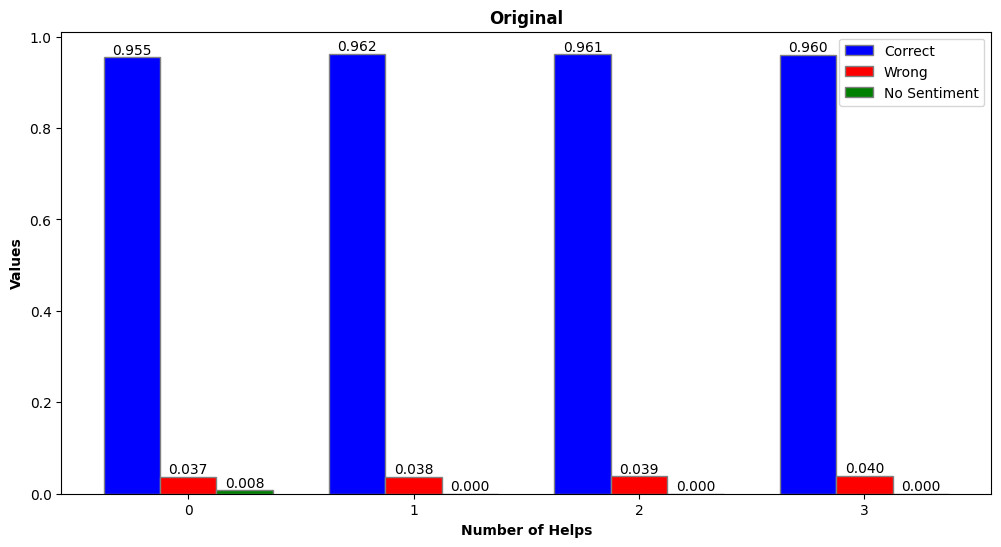

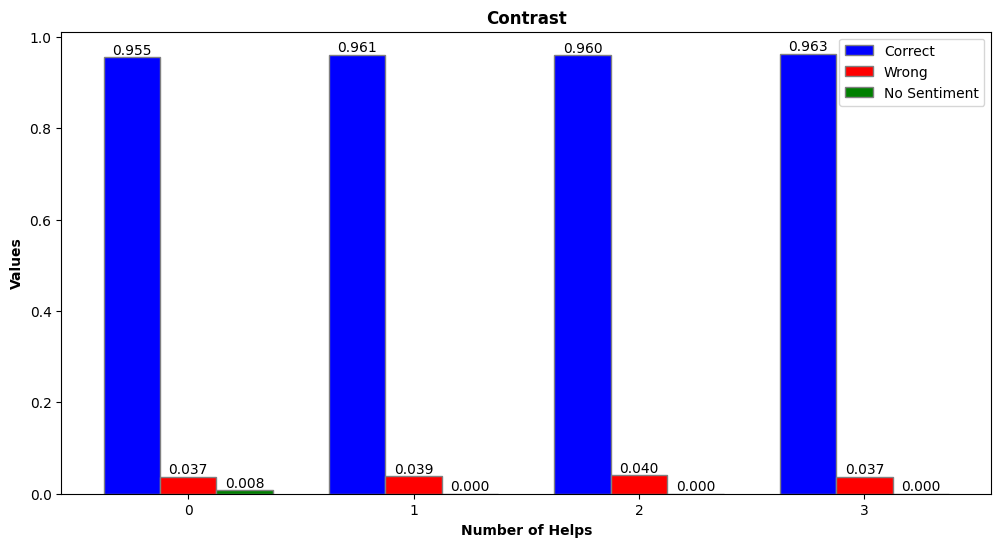

In [64]:
plot_dataframe(SP_original_mean, "SP_Original")
plot_dataframe(SP_contrast_mean, "SP_Contrast")
plot_dataframe(original_mean, "Original")
plot_dataframe(contrast_mean, "Contrast")

In [ ]:
total = []
indexes = []
original_result = [accuracy[x]['accuracy'] for x in range(len(performance_original))]
contrast_result = [performance_contrast[x]['accuracy'] for x in range(len(performance_contrast))]
shots_list = [str(x)+' Shots' for x in [y['shot'] for y in performance_original]]

for i in range(len(original_result)):
    total.append(original_result[i])
    total.append(contrast_result[i])
    indexes.append(shots_list[i])
    indexes.append(shots_list[i]+' C')

print(total)
print(indexes)

In [ ]:
plt.bar([i for i in range(len(indexes)) if i % 2 == 0], [total[i] for i in range(len(indexes)) if i % 2 == 0], color='blue', label='Original')
plt.bar([i for i in range(len(indexes)) if i % 2 != 0], [total[i] for i in range(len(indexes)) if i % 2 != 0], color='red', label='Adversarial')
plt.xticks(ticks = [i for i in range(len(indexes))], labels=[indexes[i] for i in range(len(indexes))], fontsize=6)

plt.ylabel('Accuracy')
plt.xlabel('Shots')

plt.title('Accuracy on different Few Shots Situations')
plt.legend()
plt.show()

In [ ]:
plt.bar(range(len(original_result)), original_result)
plt.xticks(ticks = [])
plt.ylabel('Accuracy')
plt.xlabel('Shots')

plt.title('Accuracy on different Few Shots Situations')
plt.legend()
plt.show()

In [ ]:
import os
os.system("paplay complete.wav")
